# Assignment 7: Decision Tree for Regression (60pts)
Only use the already imported library `numpy`, `matplotlib`, `pandas`, `graphviz`, and the Python standard library. For the evaluation, you may also use scikit-learn (`sklearn`). Make sure that the dataset `Housing.csv` is in the same directory as the notebook.

In the lecture, you saw examples of how decision trees can be used for classification tasks. In the example from the lecture, the *decision tree* was able to judge if a new mushroom is edible or not by following the tree splits based on the features of the mushroom. In regression problems, the label space is usually continuous. The goal of this exercise is to implement a *decision tree* for a regression problem.

List your team members (name and matriculation number) and indicate whether you are a B.Sc. Data Science or other groups in the following cell:

==> *Write*
* *names* Lianhan Huang 3700459   Qu Wang 3700666
* *matr. nr.* 3700459, 3700666
* *study program* both in integrative technologies and architectural design research(ITECH)
* *B.Sc./M.Sc.* M.Sc.

*of all assignment group participants here. (double click here to edit)*

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from graphviz import Digraph
from typing import Optional, Set, List, Tuple, Literal
from dataclasses import dataclass
from numpy.typing import NDArray

# Task 1: Implement Algorithm with toy dataset
In order to test our implementation lets work with a toy dataset and visualize it. The values are taken from a [blog post](https://medium.com/analytics-vidhya/regression-trees-decision-tree-for-regression-machine-learning-e4d7525d8047).




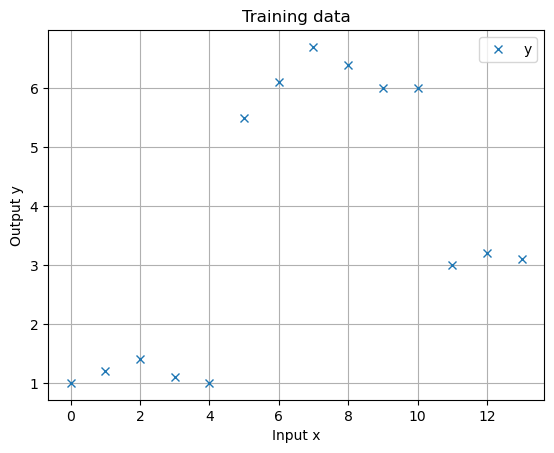

In [60]:
# Load inputs and labels
X_train = np.arange(14).reshape(-1, 1)
y_train = np.array([1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1])

# plot training data
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.set_xlabel("Input x")
ax.set_ylabel("Output y")
ax.grid()
ax.legend()
ax.set_title("Training data");

## Task 1.1 (35pts)
### Decision Tree Regressor
Implement a decision tree class `DecisionTreeRegressor`, please follow the structure below and implement the method `fit(X,y)` that is used to train the decision tree and `predict(X)` to evaluate the *fitted* decision tree. The class can get additional methods based on your needs.

### Error metric
As metric use the mean-squared error $\operatorname{MSE}:Y \times Y \rightarrow \mathbb{R}$ where the prediction is the mean over all labels in the subset, $\hat{y} = 1/n \sum_{i=1}^n y_i$, where $n$ is the number of samples in the subset and $y_i$ the true label.

For the total error use a weighted average and use the number of samples as weighting factor: 
$$\overline{MSE} = \frac{n_1 \operatorname{MSE}((y)_1,(\hat{y})_1) + n_2 \operatorname{MSE}((y)_2,(\hat{y})_2)}{n_1+n_2}$$

### Building Regression Tree
*Hint:*
- In order to train the decision tree, we suggest to first build the tree on the dataset
- You can use the *dataclasses* `Split` and `TreeNode` if you find them useful, however, this is not mandatory
- In this sample dataset, only one feature is considered. In the next example, we will increase the number of features, and therefore, your implementation should be able to handle more than one feature.
- As input features, we only consider *numerical* values; thus, you do not have to implement a separate handling for *categorical features*.

In [61]:
@dataclass
class Split:
    feature: int
    threshold: np.float64
    left: Set[NDArray[np.float64]] # X and y of left subtree
    right: Set[NDArray[np.float64]] # X and y of right subtree
    
    def __init__(self, feature: int = None, threshold: float = None, left: Set[NDArray[np.float64]] = None, right: Set[NDArray[np.float64]] = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right


@dataclass
class TreeNode:
    value: np.float64
    feature: Optional[np.float64] # int?
    threshold: Optional[np.float64]
    left: Optional["TreeNode"]
    right: Optional["TreeNode"]
    
    def __init__(self, value: np.float64 = None, feature: Optional[np.float64] = None, threshold: Optional[np.float64] = None,left: Optional['TreeNode'] = None, right: Optional['TreeNode'] = None):
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right

In [62]:
class DecisionTreeRegressor:
    def __init__(self, max_depth: int = 5, min_split: int = 2) -> None:
        """Descision tree for regression

        max_depth - maximum depth of a decision tree (default 5)
        min_split - minimum number of samples in a subtree (default 2)
        """
        self.max_depth = max_depth
        self.min_split = min_split
        self.tree = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Training method of decision tree

        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        y - labels of the training data.
        """
        assert len(X.shape) > 1
        self.tree = self._build_tree(X, y)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Prediction method of trained decision tree

        INPUT
        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        OUTPUT
        y_hat - predicted labels, size = (N)
        """
        return np.array([self._predict_one(x, self.tree) for x in X])
    
    def _build_tree(self, X: NDArray[np.float64], y: NDArray[np.float64], depth: int = 0) -> TreeNode:
        N, n = X.shape
        if N >= self.min_split and (self.max_depth is None or depth < self.max_depth):
            best_split = self._find_best_split(X, y, n)
            if best_split:
                left_indices, right_indices = self._split(X[:,best_split.feature], best_split.threshold)
                left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
                right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
                return TreeNode(
                    feature=best_split.feature,
                    threshold=best_split.threshold,
                    left=left_subtree,
                    right=right_subtree
                )
        return TreeNode(value=np.mean(y))
    
    def _find_best_split(self, X: NDArray[np.float64], y: NDArray[np.float64], n: int) -> Optional[Split]:
        best_split = None
        best_mse = float('inf')
        for feature_index in range(n):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices, right_indices = self._split(X[:, feature_index], threshold)
                if len(left_indices) > 0 and len(right_indices) > 0:
                    mse = self._calculate_total_mse(y[left_indices], y[right_indices])
                    if mse < best_mse:
                        best_mse = mse
                        best_split = Split(feature=feature_index, threshold=threshold, left=(X[left_indices], y[left_indices]), right=(X[right_indices], y[right_indices]))
        return best_split
    
    def _split(self, feature_column:NDArray[np.float64], threshold: np.float64) -> Tuple[NDArray[np.int64], NDArray[np.int64]]:
        left_indices = np.where(feature_column <= threshold)[0]
        right_indices = np.where(feature_column > threshold)[0]
        return left_indices, right_indices
    
    def _calculate_total_mse(self, left_y: NDArray[np.float64], right_y: NDArray[np.float64]) -> float:
        n_left, n_right = len(left_y), len(right_y)
        mse_left = np.mean((left_y - np.mean(left_y))**2) if n_left > 0 else 0
        mse_right = np.mean((right_y - np.mean(right_y))**2) if n_right > 0 else 0
        total_mse = (n_left * mse_left + n_right * mse_right) / (n_left + n_right)
        return total_mse
    
    def _predict_one(self, x: NDArray[np.float64], tree: TreeNode) -> np.float64:
        while tree.feature is not None and tree.threshold is not None:
            if x[tree.feature] <= tree.threshold:
                tree = tree.left
            else:
                tree = tree.right
        return tree.value
    
    def export_to_dot(self) -> str:
        def recurse(node: TreeNode, dot: Digraph, node_id: int) -> int:
            if node.feature is None:
                dot.node(str(node_id), label=f'value: {node.value:.2f}', shape='ellipse')
            else:
                dot.node(str(node_id), label=f'X[{node.feature}] <= {node.threshold:.2f}', shape='box')
                left_id = node_id + 1
                dot.edge(str(node_id), str(left_id), label='True')
                left_id = recurse(node.left, dot, left_id)
                right_id = left_id + 1
                dot.edge(str(node_id), str(right_id), label='False')
                right_id = recurse(node.right, dot, right_id)
                return right_id
            return node_id
        
        dot = Digraph()
        recurse(self.tree, dot, 0)
        return dot    
              

Now fit the decision tree to the training data

In [63]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

Evaluate the results on a discrete grid `X_eval`.

In [64]:
# Generate a grid of values over the feature space for plotting the true model
X_eval = np.linspace(0, 15, 50).reshape(-1, 1)
y_hat_eval = tree_reg.predict(X_eval)

Plot the results

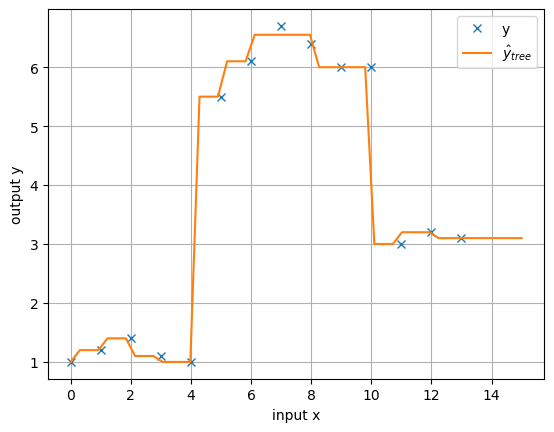

In [65]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.plot(X_eval, y_hat_eval, label=r"$\hat{y}_{tree}$")
ax.set_xlabel("input x")
ax.set_ylabel("output y")
ax.grid()
ax.legend();

# Task 1.2 (5pts)
Visualize the resulting graph using `graphviz` or any other visualization tool.

*Depending on your platform, it might be complicated to install `graphviz`. Do not spend too much time on setting it up; if you have any other way of visualizing the graph, it can also be a hand drawing; feel free to do so.*

In [66]:
# graph visualization
import os
import subprocess

os.environ['path'] += os.pathsep + 'C:\\Users\\36915\\anaconda3\envs\py39_compEx\Library\Graphviz-11.0.0-win64\\bin'
subprocess.run(['dot', '-version'], check=True)

dot = tree_reg.export_to_dot()
dot.render('decision_tree', format='png', view=True)

'decision_tree.png'

## Linear Regression model
For comparison, we use a linear regression model with quadratic features and train it on `X_train`, `y_train`. We then compare the predictions on the evaluation dataset `X_eval`.

In [67]:
class LinearRegressor:
    def __init__(self, feature_type: Literal["lin", "quad", "rbf"] = "quad") -> None:
        """Linear regression model

        feature_type - Data embedding
        """
        self.feature_type = feature_type
        self.beta_hat = None

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Training method of linear regresseion

        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        y - labels of the training data.
        """
        self.beta_hat = (
            np.linalg.inv(phi(X, self.feature_type).T @ phi(X, self.feature_type))
            @ phi(X, self.feature_type).T
            @ y
        )

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Prediction method of linear regression model

        INPUT
        X - Training dataset, size = (N, n), where N is the number of samples and n the number of features.
        OUTPUT
        y_hat - predicted labels, size = (N)
        """
        return phi(X, self.feature_type) @ self.beta_hat


def phi(
    x: NDArray[np.float64], feat_type: Literal["lin", "quad", "rbf"] = "quad"
) -> NDArray[np.float64]:
    N, nx = x.shape
    if feat_type == "lin":
        return np.hstack((np.ones((N, 1)), x))
    elif feat_type == "quad":
        if nx == 1:
            return np.hstack(
                (
                    np.ones((N, 1)),
                    x,
                    x**2,
                )
            )
        elif nx == 2:
            return np.hstack(
                (
                    np.ones((N, 1)),
                    x,
                    (x[:, 0] ** 2).reshape((N, 1)),
                    (x[:, 0] * x[:, 1]).reshape((N, 1)),
                    (x[:, 1] ** 2).reshape((N, 1)),
                )
            )
        else:
            raise NotImplementedError
    elif feat_type == "rbf":
        b = lambda x, c: np.exp(-1 / 2 * (x - c) ** 2)
        rbf_list = []
        rbf_list.append(np.ones((N, 1)))
        for j in range(0, 15, 1):
            rbf_list.append(b(x, j))
        return np.hstack(rbf_list)
    else:
        raise NotImplementedError

In [68]:
lin_reg = LinearRegressor("quad")
lin_reg.fit(X_train, y_train)
y_hat_lin_eval = lin_reg.predict(X_eval)

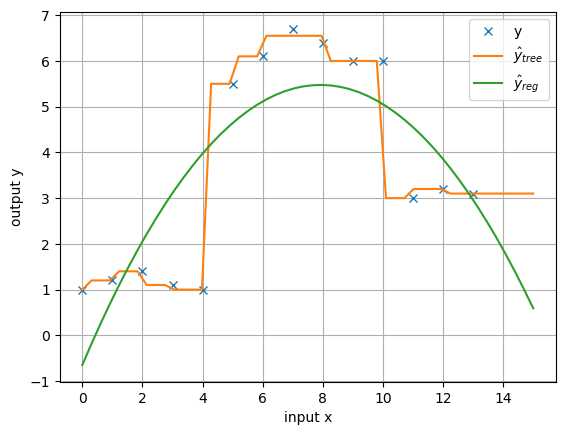

In [69]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, "x", label="y")
ax.plot(X_eval, y_hat_eval, label=r"$\hat{y}_{tree}$")
ax.plot(X_eval, y_hat_lin_eval, label=r"$\hat{y}_{reg}$")
ax.set_xlabel("input x")
ax.set_ylabel("output y")
ax.grid()
ax.legend();

## More features
In this part we will show a comparison between linear regression and a decision tree regressor for a dataset that has two features.

*Note:* **You do not have to implement anything here**, but try to understand why the results make sense by taking into account the function that generates the data and the visualizations. Feel free to play around with the hyperparameters of the decision tree and the linear regression model as well as the dataset.

In [70]:
# Generate a synthetic dataset based on a parabola
n_samples = 100
X_train = np.random.rand(n_samples, 2) * 2 - 1  # Two features in range [-1, 1]
y = X_train[:, 0] ** 2 + X_train[:, 1] ** 2  # True model without noise

# Add noise to create the observed target variable
y_train = y + np.random.randn(n_samples) * 0.1

# Train a decision tree regressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Train a linear regression model with quadratic features
lin_reg = LinearRegressor("quad")
lin_reg.fit(X_train, y_train)

# Generate a grid of values over the feature space for plotting the true model
x1_grid, x2_grid = np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)
x1, x2 = np.meshgrid(x1_grid, x2_grid)
X_test = np.c_[x1.ravel(), x2.ravel()]
y_test = x1**2 + x2**2

# Predict the target values for the grid using the trained regressors
y_hat_tree = tree.predict(X_test).reshape(x1.shape)
y_hat_lin_reg = lin_reg.predict(X_test).reshape(x1.shape)

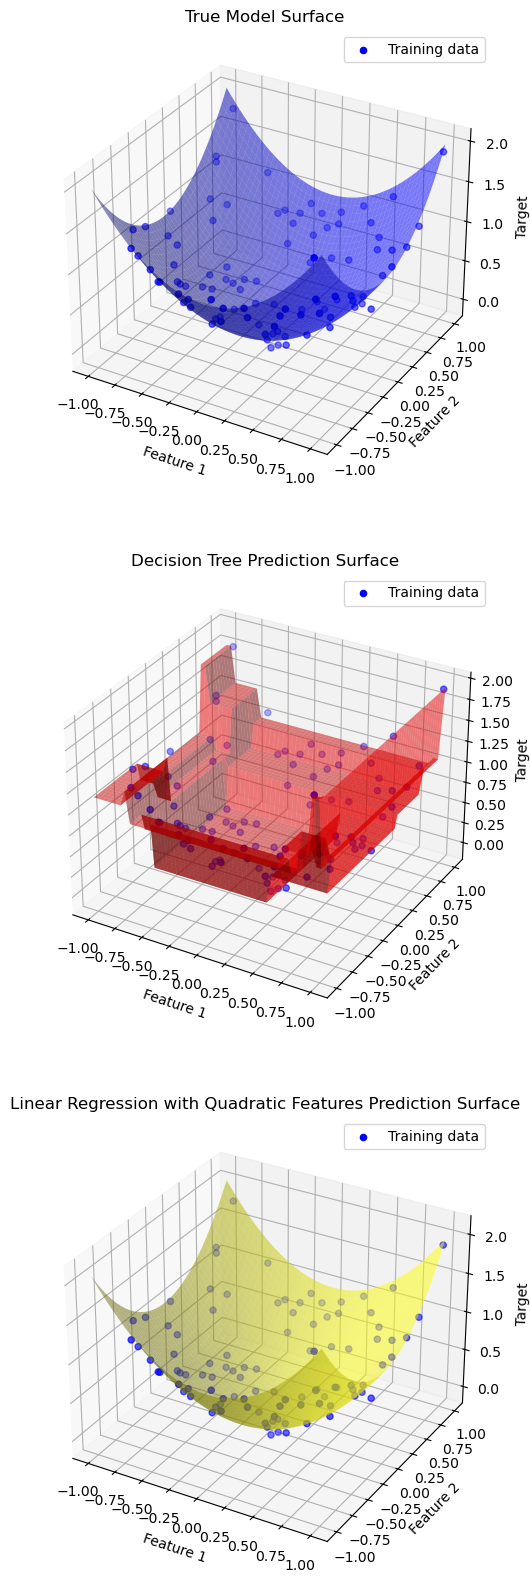

In [71]:
fig = plt.figure(figsize=(10, 20))

# Plot the true model surface
ax = fig.add_subplot(311, projection="3d")
ax.plot_surface(x1, x2, y_test, color="blue", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("True Model Surface")
ax.legend()

# Plot the decision tree prediction surface
ax = fig.add_subplot(312, projection="3d")
ax.plot_surface(x1, x2, y_hat_tree, color="red", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("Decision Tree Prediction Surface")
ax.legend()

# Plot the linear regression with quadratic features prediction surface
ax = fig.add_subplot(313, projection="3d")
ax.plot_surface(x1, x2, y_hat_lin_reg, color="yellow", alpha=0.5)
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color="blue", label="Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Target")
ax.set_title("Linear Regression with Quadratic Features Prediction Surface")
ax.legend();

# Task 2 Predict the price of American houses (20 pts)
In this part we work with the *American housing dataset* from [kaggle](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset). Please download the datafile `Housing.csv` from ILIAS and place it in the same directory as the notebook.

In [90]:
# american housing
label_name = ["price"]
feature_names = ["area", "bedrooms", "bathrooms", "stories", "parking"]
filepath = "Housing.csv"


def load_data(
    filepath: str, label_name: List[str], feature_names: List[str]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    """Load dataset from csv file

    Input:
    filepath - full file path to csv file
    label_name - column name of label
    feature_names - column name of features

    Output:
    y - labels shape(N,1)
    X - samples shape(N,n), where N is the number of samples and n is the number of features
    """
    data_df = pd.read_csv(filepath)

    return (data_df[label_name].to_numpy(), data_df[feature_names].to_numpy())


y, X = load_data(filepath, label_name, feature_names)
print(f"{y.shape}, {X.shape}")

(545, 1), (545, 5)


## Task 2.1 Data split (5pts)
Implement the method to split the data into $30\%$ test and $70\%$ training samples. You can use the method below or your own implementation.

In [82]:
def train_test_split(
    X: NDArray[np.float64], y: NDArray[np.float64], test_split: np.float64 = 0.3
) -> Tuple[
    NDArray[np.float64], NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]
]:
    N, n = X.shape
    
    #shuffle the indices
    indices = np.arange(N)
    np.random.shuffle(indices)
    
    #calculate the split point
    test_size = int(N * test_split)
    train_size = N - test_size
    
    #split the indices
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    #split the data
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train, y_train, X_test, y_test
        

y_train, X_train, y_test, X_test = train_test_split(X, y, 0.3)
print(f"{y_train.shape}, {X_train.shape}, {y_test.shape}, {X_test.shape}")

(382, 5), (382, 1), (163, 5), (163, 1)


## 2.2 Error and hyperparameter optimization (15pts)
Build the decision tree regressor with the training dataset `X_train, y_train`. Evaluate the resulting tree on the *training* and *test* dataset using a **normalized root mean squared error (NRMSE)**. Test the decision tree for different depths (change parameter `max_depth`). Plot the `max_depth` over the normalized root mean squared error.

Answer the following questions:
- What is the best value for `max_depth`?
- When comparing the NRMSE values of *training* and *test* dataset what do you observe? Can you explain your observation?


In [101]:
def compute_nrmse(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    nrmse = rmse / (np.max(y_true) - np.min(y_true))
    return nrmse

In [102]:
#initialize lists to store NRMSE values
train_nrmse_list = []
test_nrmse_list = []
depths = range(1, 21)

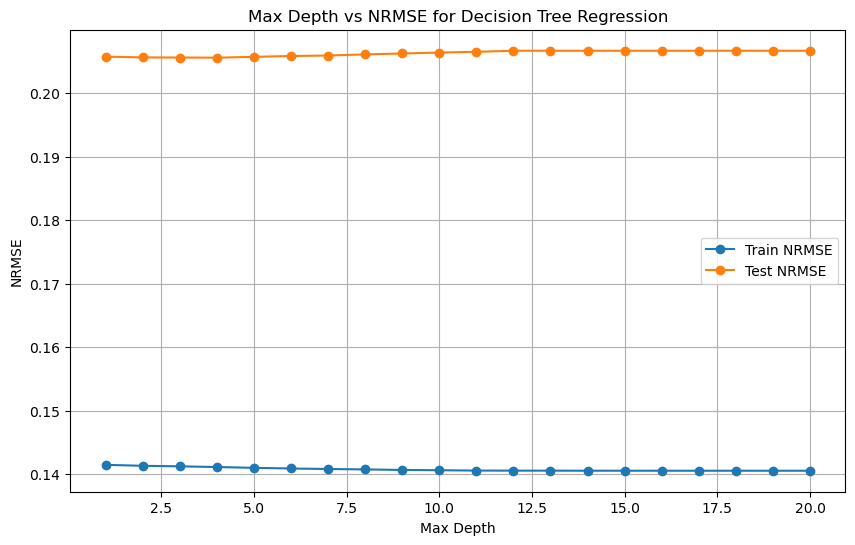

In [103]:
#train and evaluate the decision tree for different depths
for depth in depths:
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X_train, y_train)
    
    #predictions
    y_train_pred = tree_reg.predict(X_train)
    y_test_pred = tree_reg.predict(X_test)
    
    #convert 1d array of predicted y into 2d array
    y_train_pred = y_train_pred.reshape((y_train_pred.size, 1))
    y_test_pred = y_test_pred.reshape((y_test_pred.size, 1))
    
    #compute NRMSE
    train_nrmse = compute_nrmse(y_train, y_train_pred)
    test_nrmse = compute_nrmse(y_test, y_test_pred)
    
    train_nrmse_list.append(train_nrmse)
    test_nrmse_list.append(test_nrmse)
    
#plot max_depth versus NRMSE
plt.figure(figsize=(10,6))
plt.plot(depths, train_nrmse_list, label="Train NRMSE", marker="o")
plt.plot(depths, test_nrmse_list, label="Test NRMSE", marker="o")
plt.xlabel('Max Depth')
plt.ylabel('NRMSE')
plt.title("Max Depth vs NRMSE for Decision Tree Regression")
plt.legend()
plt.grid(True)
plt.show()
